# Recipe Traffic Classification - Data Scientist Practical Exam Submission


# **DATA VALIDATION**

In [ ]:
# necessary libraries/modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
sns.set_palette('deep')

# Or, if you want to customize specific settings:
plt.rcParams.update({
    'axes.facecolor': 'whitesmoke',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'axes.grid': True,
})

In [ ]:
# inspect DataFrame

file_path = '/content/recipe_site_traffic_2212.csv'
rst = pd.read_csv(file_path, delimiter = ',')

# inspect dtypes, shape, and table
print(rst.dtypes)
print(rst.shape)

rst.head()

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object
(947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [ ]:
# null values?

print(rst.isna().sum())

# from this result, can ignore recipe, category, servings for now
# how to validate whether the 52 results that don't have macronutrient information (calories, carbs, sugar, protein) are the same 52 recipes?

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


In [ ]:
# idea: create a set with the index values that contain missing values for the calories, carbohydrate, sugar, and protein columns. Then, cross-reference them.

# create four sets, one for Calories and the three Macronutrients present
missing_calories = set(rst['calories'].isnull().index)
missing_calories = set(rst['carbohydrate'].isnull().index)
missing_sugar = set(rst['sugar'].isnull().index)
missing_protein = set(rst['protein'].isnull().index)

# check if they match each other
all_match = missing_calories ==  missing_calories == missing_sugar == missing_protein

# if all match, print statement indicating such
if all_match == True:
    print('Yes, the missing values are all from the same 52 recipes.')
else:
    print('No, further analysis is required.')

Yes, the missing values are all from the same 52 recipes.


In [ ]:
# idea: to deal with the missing values in calories, carbohydrate, sugar, and protein, fill each with the mean for each type of breakfast

# check unique and number unique for Category
categories_of_meals = rst['category'].unique()
categories_of_meals_num = rst['category'].nunique()

print(f'There are {categories_of_meals_num} categories of meals: {categories_of_meals}')

There are 11 categories of meals: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


In [ ]:
# idea: for missing (NaN) values in numerical columns, fill with the mean for each column

# identify columns to fill
columns_to_fill = ['calories', 'carbohydrate', 'sugar', 'protein']

# calculate means
means = rst.groupby('category')[columns_to_fill].transform('mean')

# fill missing (NaN) values with mean of each column
rst[columns_to_fill] = rst[columns_to_fill].fillna(means)

# round to 2 decimal places
rst[['calories', 'carbohydrate', 'sugar', 'protein']] = rst[['calories', 'carbohydrate', 'sugar', 'protein']].round(2)

```python
# the following two cells are presented in markdown. This idea was scrapped because it made "Meat" as a feature of the future models too overbearing.

# last order of business: collapsing all the different types of meat under one label. First, create a new column that will indicate whether the meal contains Pork.

# creation of new row
rst['contains_pork'] = rst['category'].apply(lambda x: 'Pork' in x)
```

```python
# previous cell cont.

# identify columns
meat_types = ['Pork', 'Chicken', 'Chicken Breast']

# replace specific meat types with "Meat"
rst['category'] = rst['category'].replace(meat_types, 'Meat')

print(rst['category'].unique())
```

In [ ]:
# idea: to ensure 10 recipe types as outlined by instructions, reclassify "Chicken Breast" as "Chicken"

rst['category'] = rst['category'].replace('Chicken Breast', 'Chicken')

rst['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

In [ ]:
# idea: dealing with high_traffic column

# first, check unique values
print(rst['high_traffic'].unique())

['High' nan]


In [ ]:
# previous cell cont.

# replace missing (NaN) values with "Low"
rst['high_traffic'] = rst['high_traffic'].fillna('Low')

print(rst['high_traffic'].unique())

print(rst['high_traffic'].value_counts())

# so, there's only two unique values: 'High' and Null. Out of 947 entries, more than a third of them didn't experience 'High' traffic

['High' 'Low']
high_traffic
High    574
Low     373
Name: count, dtype: int64


In [ ]:
# idea: deal with discrepancies in the Servings columns by standardising the available values

rst['servings'] = rst['servings'].replace(['4 as a snack', '6 as a snack'], ['4', '6'])

rst['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

In [ ]:
# idea: add a column for fat in grams. This will make the dataset more robust and representational of the three way macronutrient split (protein, fat, carbohydrates).

# equation: ((calories) - ((carbohydrate*4) + (protein*4)))/9
rst['servings'] = rst['servings'].astype('float64')
rst['fat'] = round((rst['calories'] - ((rst['carbohydrate'] * 4) + (rst['protein'] * 4)))/9, 2)

# check if any values are less than zero
count = []

for x in rst['fat']:
    if x < 0:
        count.append(x)

print(f'Number of non-positive values for "fat" before removal: {len(count)}\n')

# for any values that end up less than zero, set fat to zero (unrealistic in most contexts unless the food item is highly specific, but necessary nonetheless)
rst.loc[rst['fat'] < 0, 'fat'] = 0

print(f'Number of non-positive values for "fat" after removal: {(rst["fat"] < 0).sum()}')

'''
interpretation: the length of count being what it is suggests 1 thing: that many of the data in the DataFrame aren't very reliable, at least for ~ 300 of the entries.
For the amount of fat to be negative indicates that the number of carbohydrates + protein alone exceeds the listed calorie count - even when accounting for the number of servings.
Consider excluding these rows from analysis.
'''

Number of non-positive values for "fat" before removal: 324

Number of non-positive values for "fat" after removal: 0


"\ninterpretation: the length of count being what it is suggests 1 thing: that many of the data in the DataFrame aren't very reliable, at least for ~ 300 of the entries.\nFor the amount of fat to be negative indicates that the number of carbohydrates + protein alone exceeds the listed calorie count - even when accounting for the number of servings.\nConsider excluding these rows from analysis.\n"

In [ ]:
# final table, unmodified

rst = rst.reindex(columns = ['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'fat', 'category', 'servings', 'high_traffic'])
pd.set_option('display.max_columns', None)

rst.head(50)

,recipe,calories,carbohydrate,sugar,protein,fat,category,servings,high_traffic
0,1,629.71,28.08,8.04,43.80,38.02,Pork,6.0,High
1,2,35.48,38.56,0.66,0.92,0.00,Potato,4.0,High
2,3,914.28,42.68,3.09,2.88,81.34,Breakfast,1.0,Low
3,4,97.03,30.56,38.63,0.02,0.00,Beverages,4.0,High
4,5,27.05,1.85,0.80,0.53,1.95,Beverages,4.0,Low
5,6,691.15,3.46,1.65,53.93,51.29,One Dish Meal,2.0,High
6,7,183.94,47.95,9.75,46.71,0.00,Chicken,4.0,Low
7,8,299.14,3.17,0.40,32.40,17.43,Lunch/Snacks,4.0,Low
8,9,538.52,3.78,3.37,3.79,56.47,Pork,6.0,High
9,10,248.28,48.54,3.99,113.85,0.00,Chicken,2.0,Low


In [ ]:
# final table, modified for ML purposes: removed rows where protein + carbs expressed in terms of calories is greater than the total calorie count. Margin of error for calorie counts is 20% per the FDA.

modified_condition = ((rst['protein'] * 4) + rst['carbohydrate'] * 4) > (rst['calories'] * 1.2)
rst_modified = rst.drop(rst[modified_condition].index)
rst_modified = rst_modified.reindex(columns = ['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'fat', 'category', 'servings', 'high_traffic'])
rows_del = rst.shape[0] - rst_modified.shape[0]
print(f'The number of rows excluded is: {rows_del}\n')

rst_modified.head(50)

The number of rows excluded is: 282



,recipe,calories,carbohydrate,sugar,protein,fat,category,servings,high_traffic
0,1,629.71,28.08,8.04,43.80,38.02,Pork,6.0,High
2,3,914.28,42.68,3.09,2.88,81.34,Breakfast,1.0,Low
4,5,27.05,1.85,0.80,0.53,1.95,Beverages,4.0,Low
5,6,691.15,3.46,1.65,53.93,51.29,One Dish Meal,2.0,High
7,8,299.14,3.17,0.40,32.40,17.43,Lunch/Snacks,4.0,Low
8,9,538.52,3.78,3.37,3.79,56.47,Pork,6.0,High
10,11,170.12,17.63,4.10,0.91,10.66,Beverages,1.0,Low
11,12,155.80,8.27,9.78,11.55,8.50,Breakfast,6.0,Low
12,13,274.63,23.49,1.56,2.57,18.93,Potato,4.0,High
14,15,217.14,6.69,10.00,15.17,14.41,Meat,4.0,High


# **EXPLORATORY ANALYSIS**

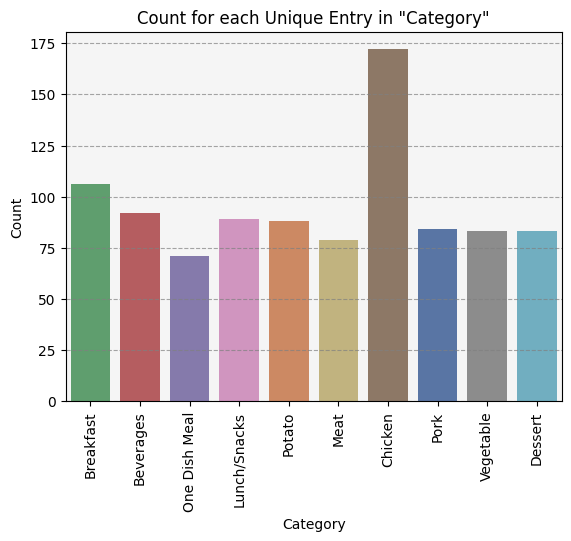

In [ ]:
# idea (single-var 1): countplot showing how many of each recipe type there are

plot0 = sns.countplot(
    rst,
    x = 'category',
    hue = 'category',
    order = ['Breakfast', 'Beverages', 'One Dish Meal', 'Lunch/Snacks', 'Potato', 'Meat', 'Chicken', 'Pork', 'Vegetable', 'Dessert']
)

plot0.set_xlabel('Category')
plot0.set_ylabel('Count')
plot0.set_title('Count for each Unique Entry in "Category"')
plt.xticks(rotation = 90)

plt.show()

# interpretation: this graph shows the count for each unique entry for category.

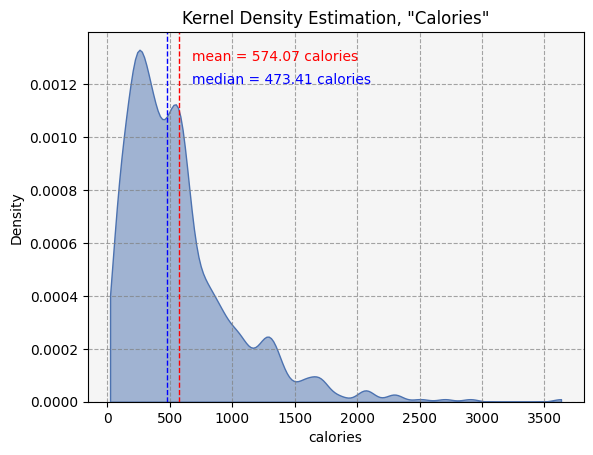

'\ninterpretation: the distribution of this dataset (in terms of calories) is very skewed right, confirmed by the mean being farther to the right than the median and the "tail"\nextending rightward. On average, the recipes have almost 575 calories. Half of the recipes have less than around 470 calories, while half have more.\n'

In [ ]:
# idea (single-var 2): KDE  plot to show the calority density across all recipes

plot1 = sns.kdeplot(
    data = rst_modified['calories'],
    clip = (rst_modified['calories'].min(), rst_modified['calories'].max()),
    alpha = .5,
    fill = True,
    bw_adjust = .5
)

mean_value = np.mean(rst_modified['calories'])
median_value = np.median(rst_modified['calories'])
plot1.axvline(mean_value, color = 'red', linestyle = 'dashed', linewidth = 1)
plot1.axvline(median_value, color = 'blue', linestyle = 'dashed', linewidth = 1)
plot1.text(mean_value + 100, 0.00129, f'mean = {round(mean_value, 2)} calories', color = 'red', rotation = 0, fontsize = 10)
plot1.text(median_value + 2 * (mean_value - median_value), 0.0012, f'median = {round(median_value, 2)} calories', color = 'blue', fontsize = 10)
plot1.set_title('Kernel Density Estimation, "Calories"')

plt.show()

'''
interpretation: the distribution of this dataset (in terms of calories) is very skewed right, confirmed by the mean being farther to the right than the median and the "tail"
extending rightward. On average, the recipes have almost 575 calories. Half of the recipes have less than around 470 calories, while half have more.
'''

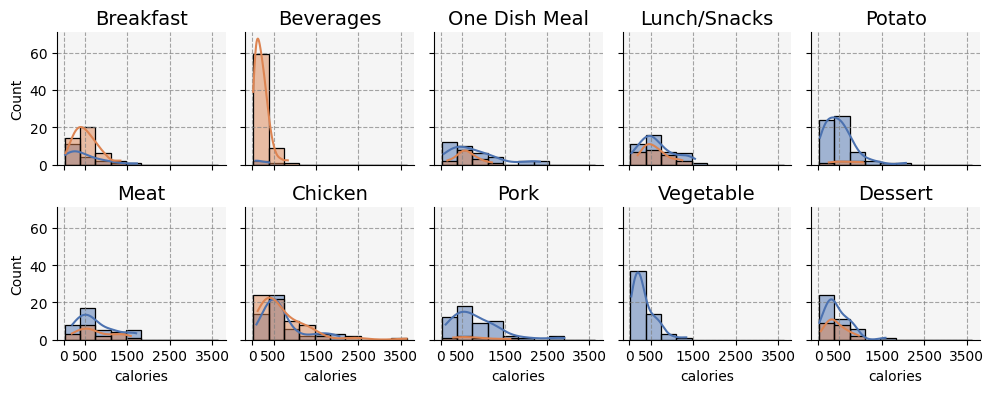

'\ninterpretation: when investigating the calorie count by Category, it seems that each individual value for category is also skewed right.\nSome categories have a much higher concentration of lower calorie options, like Beverages, while categories like One Dish Meal and Lunch/Snacks have a wider distribution.\n'

In [ ]:
# idea (single-var 3):

plot2 = sns.FacetGrid(
    rst_modified,
    col = 'category',
    col_wrap = 5,
    height = 2,
    col_order = ['Breakfast', 'Beverages', 'One Dish Meal', 'Lunch/Snacks', 'Potato', 'Meat', 'Chicken', 'Pork',
                 'Vegetable', 'Dessert'],
    hue = 'high_traffic'
)

bin_edges = np.histogram(rst_modified['calories'], bins = 10)[1]
plot2.map(sns.histplot, 'calories', bins = bin_edges, kde = True)
plot2.set(xticks = [0, 500, 1500, 2500, 3500])
plot2.set_titles("{col_name}", size=14)

plt.show()

'''
interpretation: when investigating the calorie count by Category, it seems that each individual value for category is also skewed right.
Some categories have a much higher concentration of lower calorie options, like Beverages, while categories like One Dish Meal and Lunch/Snacks have a wider distribution.
'''

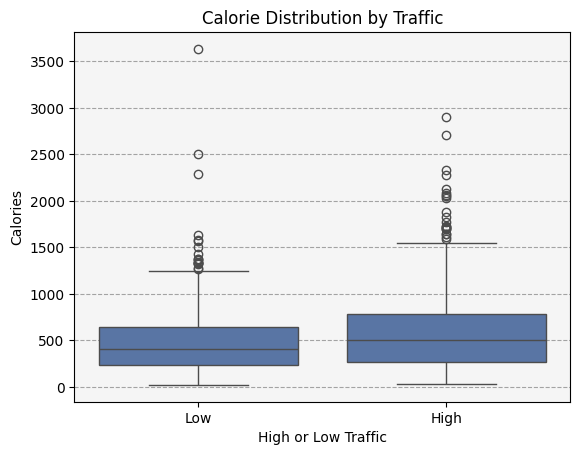

'\ninterpretation: an exploratory look in to how Calories migth suffice as a variable in model selection. While there seems to be a trend of higher calorie options being more popular,\nthere also seem to be a lot of outliers that some models might have a hard time dealing with.\n'

In [ ]:
# idea (multi-var 1): relation between calorie count and whether the traffic is high or low

order = ['Low', 'High']

plot3 = sns.boxplot(
    x = 'high_traffic',
    y = 'calories',
    data = rst_modified,
    order = order
)

plt.title('Calorie Distribution by Traffic')
plot3.set_xlabel('High or Low Traffic')
plot3.set_ylabel('Calories')

plt.show()

'''
interpretation: an exploratory look in to how Calories migth suffice as a variable in model selection. While there seems to be a trend of higher calorie options being more popular,
there also seem to be a lot of outliers that some models might have a hard time dealing with.
'''

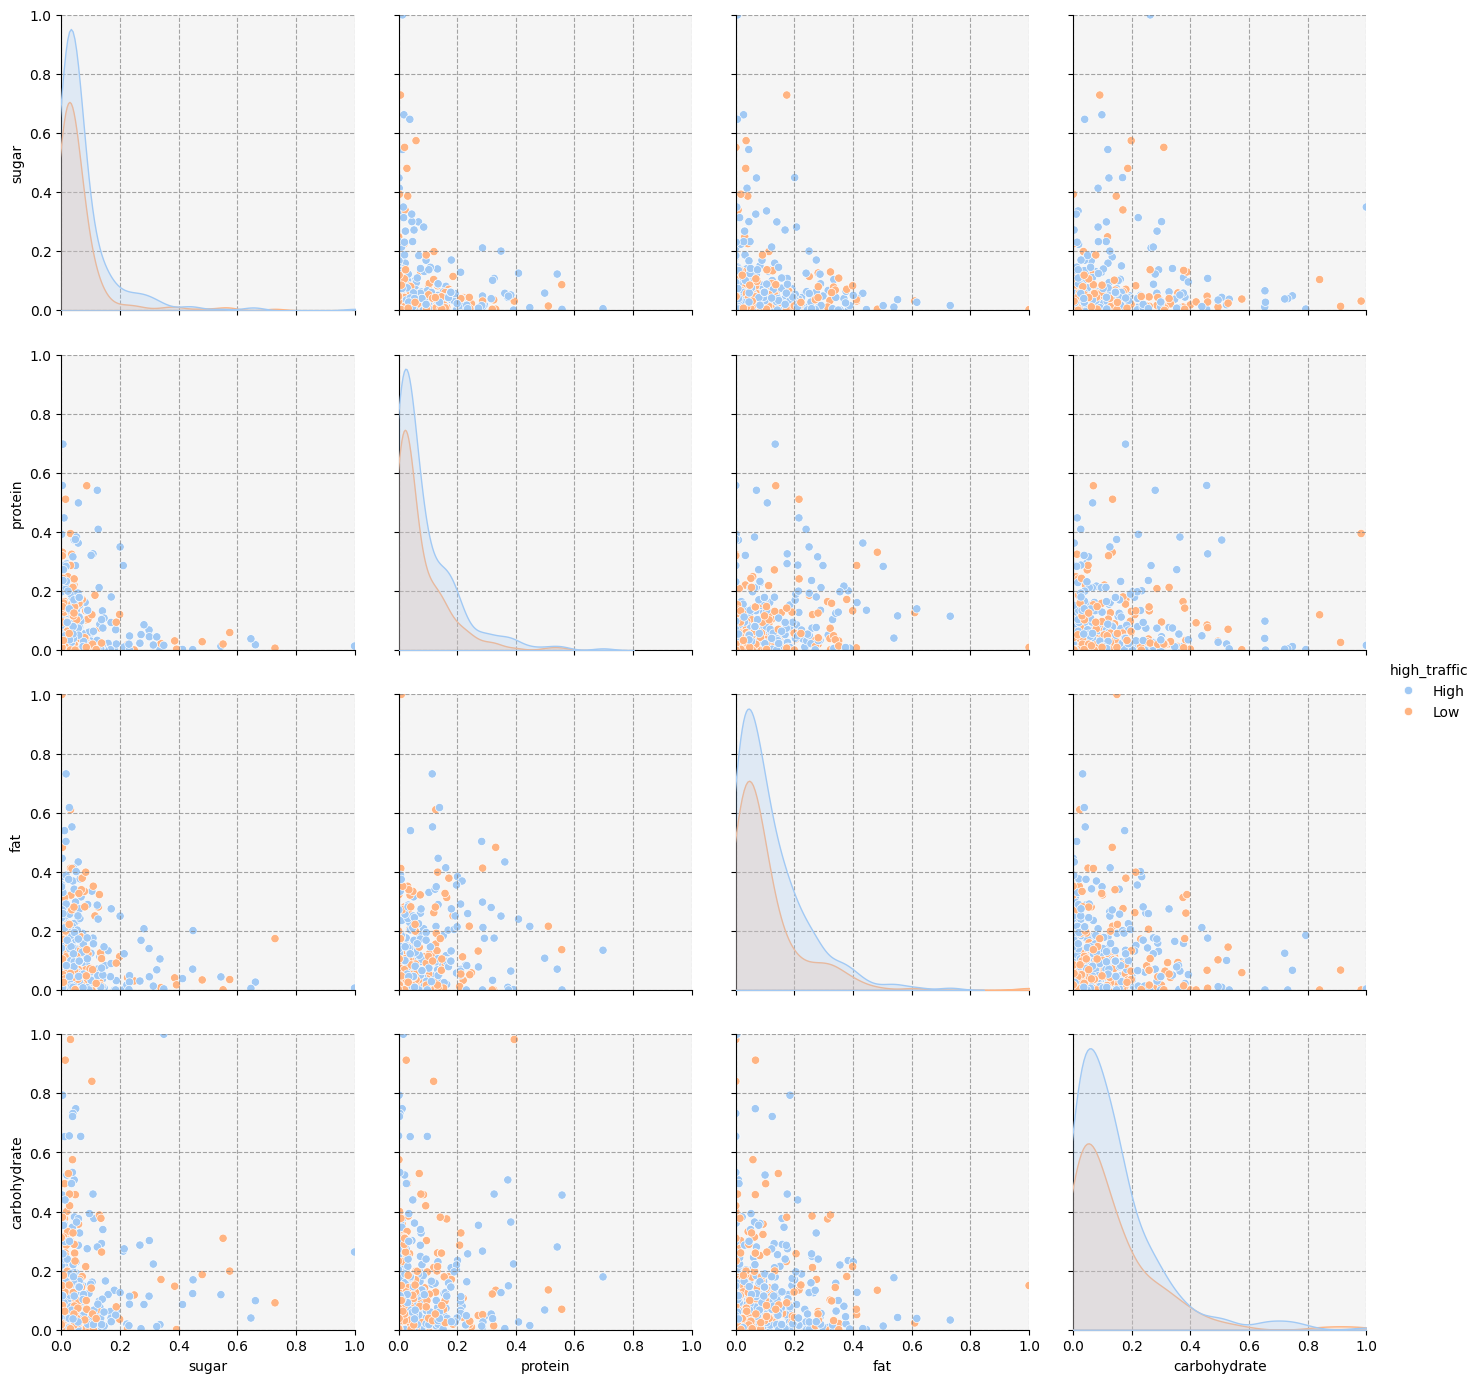

"\ninterpretation: an exploratory look in to how Macronutrients + Sugar might suffice as a variable in model selection. Each relationship acts as expected - as one macronutrient icreases, the others\ndecrease (this relationship may have been less clear without the removal of a portion of the dataset earlier). The relationship between Macronutrients + Sugar and Traffic is less clear.\nHigh overlap between the two groups seems to indicate that Macronutrient + Sugar isn't the best indicator of traffic.\n"

In [ ]:
# idea (multi-var 2): pairplot

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# columns to investigate
cols_for_pairplot = ['sugar', 'protein', 'fat', 'carbohydrate']

# create and apply scaler, MinMaxScaler
scaler = MinMaxScaler()
rst_mac_scaled = pd.DataFrame(scaler.fit_transform(rst_modified[cols_for_pairplot]), columns = cols_for_pairplot)

# unscaled target column
rst_mac_scaled['high_traffic'] = rst_modified['high_traffic']

# create pairplot
plot4 = sns.pairplot(
    rst_mac_scaled,
    hue = 'high_traffic',
    diag_kind = 'kde',
    diag_kws = {'common_norm': True},
    height = 3.5,
    palette = 'pastel'
)

# standardise x and y axis limits for all subplots
xlim = [rst_mac_scaled[cols_for_pairplot].min().min(), rst_mac_scaled[cols_for_pairplot].max().max()]
ylim = [rst_mac_scaled[cols_for_pairplot].min().min(), rst_mac_scaled[cols_for_pairplot].max().max()]

for ax in plot4.axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# spacing between the subplots
plt.subplots_adjust(hspace = 0.15, wspace = 0.15)

plt.show()

'''
interpretation: an exploratory look in to how Macronutrients + Sugar might suffice as a variable in model selection. Each relationship acts as expected - as one macronutrient icreases, the others
decrease (this relationship may have been less clear without the removal of a portion of the dataset earlier). The relationship between Macronutrients + Sugar and Traffic is less clear.
High overlap between the two groups seems to indicate that Macronutrient + Sugar isn't the best indicator of traffic.
'''

# **MODEL DEVELOPMENT**

In [ ]:
# necessary libraries/modules for ML models

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, log_loss, brier_score_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [ ]:
# idea: decision tree, macronutrients and sugar

# features X, target y, convert catagorical variables to dummy variables, excluding fat because of potential unreliability
X_mac = (rst_modified[['carbohydrate', 'sugar', 'protein']])
y_mac = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# split data into train, test
X_train_mac, X_test_mac, y_train_mac, y_test_mac = train_test_split(X_mac, y_mac, test_size = 0.3, random_state = 42)

start_time = time.time()

# train decision tree classifier
clf_mac = DecisionTreeClassifier(random_state = 42)
clf_mac.fit(X_train_mac, y_train_mac)

# predict adn evaluate
y_pred_mac = clf_mac.predict(X_test_mac)

print(classification_report(y_test_mac, y_pred_mac))

end_time = time.time()
execution_time = end_time - start_time
print(f"Model training and evaluation completed in {execution_time:.4f} seconds")

              precision    recall  f1-score   support

           0       0.63      0.55      0.59        91
           1       0.66      0.73      0.70       109

    accuracy                           0.65       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.65      0.65      0.65       200

Model training and evaluation completed in 0.0339 seconds


In [ ]:
# idea: random forest, category

# features X, target y
X_rf = pd.get_dummies(rst_modified[['category', 'carbohydrate', 'sugar', 'protein']])
y_rf = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# split data into training, test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size = 0.3, random_state = 42)

start_time = time.time()

# train random forest classifier
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train_rf, y_train_rf)

# predict, evaluate
y_pred_rf = rf_clf.predict(X_test_rf)

print(classification_report(y_test_rf, y_pred_rf))

end_time = time.time()
execution_time = end_time - start_time
print(f"Model training and evaluation completed in {execution_time:.4f} seconds")

              precision    recall  f1-score   support

           0       0.70      0.63      0.66        91
           1       0.71      0.78      0.75       109

    accuracy                           0.71       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.71      0.71      0.71       200

Model training and evaluation completed in 0.3399 seconds


In [ ]:
# idea: decision tree, category

# features X, target y
X_cat = pd.get_dummies(rst_modified['category'])
y_cat = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# split data into training, test
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, stratify = y_cat, test_size = 0.3, random_state = 42)

# establish params to be tuned
DT_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

start_time = time.time()

# train decision tree classifier
clf_cat = GridSearchCV(DecisionTreeClassifier(random_state = 42), DT_params, cv = 15, n_jobs = -1, scoring = 'accuracy')
clf_cat.fit(X_train_cat, y_train_cat)

# predict, evaluate
clf_cat_best = clf_cat.best_estimator_
y_pred_cat = clf_cat_best.predict(X_test_cat)

print(classification_report(y_test_cat, y_pred_cat))

end_time = time.time()
execution_time = end_time - start_time
print(f'Model training and evaluation completed in {execution_time:.4f} seconds\n')

# predict probabilities
y_probs_DT = clf_cat_best.predict_proba(X_test_cat)[:, 1]

# log loss
logloss = log_loss(y_test_cat, y_probs_DT)
print(f'Log Loss: {logloss:.4f}')

# Brier score
brier = brier_score_loss(y_test_cat, y_probs_DT)
print(f'Brier Score: {brier:.4f}')

              precision    recall  f1-score   support

           0       0.69      0.66      0.68        79
           1       0.78      0.81      0.80       121

    accuracy                           0.75       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.75      0.75      0.75       200

Model training and evaluation completed in 7.0711 seconds

Log Loss: 1.0331
Brier Score: 0.1802


    Threshold  Accuracy  Precision    Recall  F1-Score
0        0.10     0.705   0.678161  0.975207  0.800000
1        0.15     0.705   0.678161  0.975207  0.800000
2        0.20     0.705   0.678161  0.975207  0.800000
3        0.25     0.705   0.678161  0.975207  0.800000
4        0.30     0.730   0.713376  0.925620  0.805755
5        0.35     0.730   0.713376  0.925620  0.805755
6        0.40     0.730   0.713376  0.925620  0.805755
7        0.45     0.750   0.784000  0.809917  0.796748
8        0.50     0.750   0.784000  0.809917  0.796748
9        0.55     0.750   0.784000  0.809917  0.796748
10       0.60     0.750   0.784000  0.809917  0.796748
11       0.65     0.750   0.784000  0.809917  0.796748
12       0.70     0.750   0.784000  0.809917  0.796748
13       0.75     0.750   0.784000  0.809917  0.796748
14       0.80     0.750   0.784000  0.809917  0.796748
15       0.85     0.395   0.000000  0.000000  0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


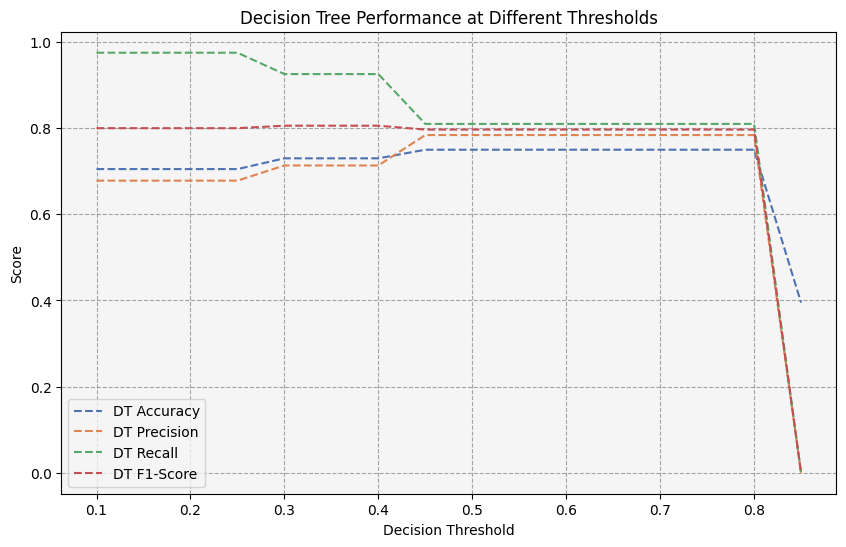

In [ ]:
# idea: evaluate decision tree at different thresholds

# different thresholds 0.1 - 0.9, increments of 0.05
thresholds = np.arange(0.1, 0.9, 0.05)
DT_results = []

# loop through each threshold
for threshold in thresholds:
    y_pred_DT = (y_probs_DT >= threshold).astype(int)

    # establish metrics
    precision = precision_score(y_test_cat, y_pred_DT)
    recall = recall_score(y_test_cat, y_pred_DT)
    f1 = f1_score(y_test_cat, y_pred_DT)
    accuracy = accuracy_score(y_test_cat, y_pred_DT)

    # store results
    DT_results.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# convert to DataFrame
DT_results_df = pd.DataFrame(DT_results)

# results sorted by threshold
print(DT_results_df.sort_values(by = 'Threshold'))

# plot performance at different thresholds
plt.figure(figsize = (10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(
        thresholds,
        DT_results_df
        [metric],
        label = f'DT {metric}',
        linestyle = '--'
    )

plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.title('Decision Tree Performance at Different Thresholds')

plt.show()

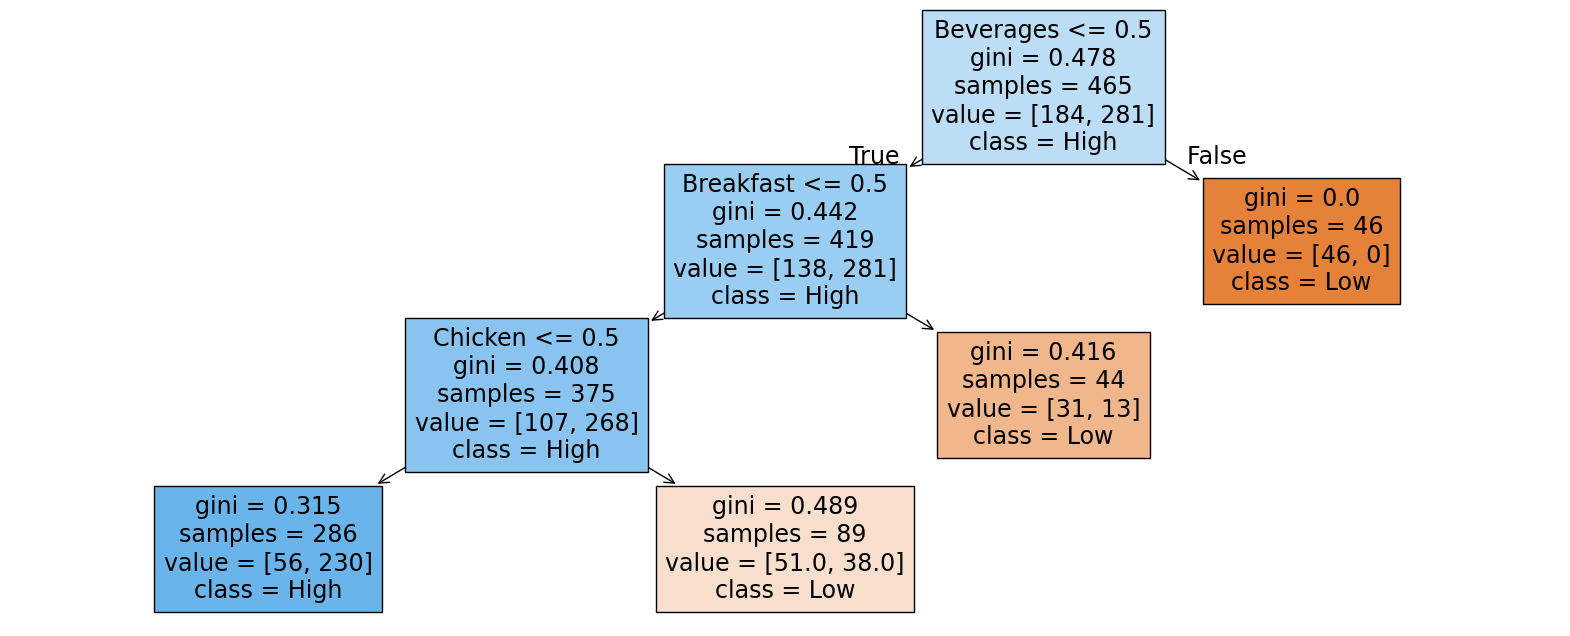

In [ ]:
# idea: visualisation of decision tree

plt.figure(figsize = (20, 8))

plot_tree(
    clf_cat_best,
    feature_names = X_cat.columns,
    class_names = ['Low', 'High'],
    filled = True
)

plt.show()

In [ ]:
# idea: for the available data, what are the corresponding High:Low ratios for each value for category?

rst_modified['high_traffic_binary'] = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# group by category
traffic_ratio = rst_modified.groupby('category').agg(
    High_Traffic_Ratio = ('high_traffic_binary', 'mean'),
    Count_Instances = ('high_traffic_binary', 'count')
).reset_index()

# sort by highest ratio
traffic_ratio = traffic_ratio.sort_values(by = 'High_Traffic_Ratio', ascending = False)

print(traffic_ratio)

        category  High_Traffic_Ratio  Count_Instances
9      Vegetable            1.000000               55
8         Potato            0.924242               66
7           Pork            0.915254               59
6  One Dish Meal            0.720000               50
3        Dessert            0.688525               61
5           Meat            0.684211               57
4   Lunch/Snacks            0.650794               63
2        Chicken            0.429752              121
1      Breakfast            0.311475               61
0      Beverages            0.041667               72


In [ ]:
# feature importance

# create dataframe, sort values by Importance
feature_importance = pd.DataFrame({
    'Feature': X_cat.columns,
    'Importance': clf_cat_best.feature_importances_
}).sort_values(by = "Importance", ascending = False)

print(feature_importance)

         Feature  Importance
0      Beverages    0.529284
2        Chicken    0.274234
1      Breakfast    0.196482
3        Dessert    0.000000
4   Lunch/Snacks    0.000000
5           Meat    0.000000
6  One Dish Meal    0.000000
7           Pork    0.000000
8         Potato    0.000000
9      Vegetable    0.000000


In [ ]:
# idea: compare decision tree model to gradient boosting

X_cat_GB = pd.get_dummies(rst_modified['category'])
y_cat_GB = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# split data into training, test
X_train_cat_GB, X_test_cat_GB, y_train_cat_GB, y_test_cat_GB = train_test_split(X_cat_GB, y_cat_GB, stratify = y_cat_GB, test_size = 0.3, random_state = 42)

# establish param to be tuned
GB_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

start_time = time.time()

# train gradient boosting classifier
clf_cat_GB = GridSearchCV(GradientBoostingClassifier(random_state = 42),
                          GB_params,
                          cv = 15,
                          n_jobs = -1,
                          scoring ='accuracy'
                         )
clf_cat_GB.fit(X_train_cat_GB, y_train_cat_GB)

# predict, evaluate
clf_cat_GB_best = clf_cat_GB.best_estimator_
y_pred_cat_GB = clf_cat_GB_best.predict(X_test_cat_GB)

print(classification_report(y_test_cat_GB, y_pred_cat_GB))

end_time = time.time()
execution_time = end_time - start_time
print(f'Model training and evaluation completed in {execution_time:.4f} seconds\n')

# predict probabilities
y_probs_GB = clf_cat_GB_best.predict_proba(X_test_cat_GB)[:, 1]

# log loss
logloss = log_loss(y_test_cat_GB, y_probs_GB)
print(f'Log Loss: {logloss:.4f}')

# Brier score
brier = brier_score_loss(y_test_cat_GB, y_probs_GB)
print(f'Brier Score: {brier:.4f}')

              precision    recall  f1-score   support

           0       0.69      0.66      0.68        79
           1       0.78      0.81      0.80       121

    accuracy                           0.75       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.75      0.75      0.75       200

Model training and evaluation completed in 133.4739 seconds

Log Loss: 0.5152
Brier Score: 0.1716


    Threshold  Accuracy  Precision    Recall  F1-Score
0        0.10     0.705   0.678161  0.975207  0.800000
1        0.15     0.705   0.678161  0.975207  0.800000
2        0.20     0.705   0.678161  0.975207  0.800000
3        0.25     0.705   0.678161  0.975207  0.800000
4        0.30     0.705   0.678161  0.975207  0.800000
5        0.35     0.730   0.713376  0.925620  0.805755
6        0.40     0.730   0.713376  0.925620  0.805755
7        0.45     0.730   0.713376  0.925620  0.805755
8        0.50     0.750   0.784000  0.809917  0.796748
9        0.55     0.750   0.784000  0.809917  0.796748
10       0.60     0.750   0.784000  0.809917  0.796748
11       0.65     0.750   0.784000  0.809917  0.796748
12       0.70     0.630   0.830986  0.487603  0.614583
13       0.75     0.605   0.937500  0.371901  0.532544
14       0.80     0.605   0.937500  0.371901  0.532544
15       0.85     0.505   0.923077  0.198347  0.326531


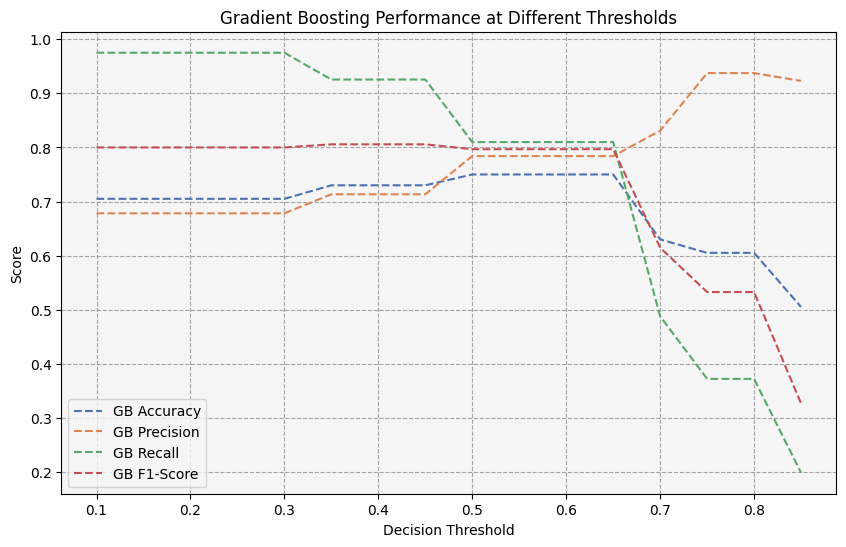

In [ ]:
# idea: evaluate gradient boosting at different thresholds

# different thresholds 0.1 - 0.9, increments of 0.05
thresholds = np.arange(0.1, 0.9, 0.05)
GB_results = []

# loop through each thresholds
for threshold in thresholds:
    y_pred_GB = (y_probs_GB >= threshold).astype(int)  # apply threshold

    # establish metrics
    precision = precision_score(y_test_cat_GB, y_pred_GB)
    recall = recall_score(y_test_cat_GB, y_pred_GB)
    f1 = f1_score(y_test_cat_GB, y_pred_GB)
    accuracy = accuracy_score(y_test_cat_GB, y_pred_GB)

    # store results
    GB_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# covert to DataFrame
GB_results_df = pd.DataFrame(GB_results)

# results sorted by threshold
print(GB_results_df.sort_values(by = "Threshold"))

# plot Performance at Different thresholds
plt.figure(figsize = (10, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(
        thresholds,
        GB_results_df[metric],
        label = f'GB {metric}',
        linestyle = '--'
    )

plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.title('Gradient Boosting Performance at Different Thresholds')

plt.show()

In [ ]:
# idea: optimise gradient boosting performance method by using LightGBM, usign SMOTE

X_cat_LGB = pd.get_dummies(rst_modified['category'])
y_cat_LGB = rst_modified['high_traffic'].map({'Low': 0, 'High': 1})

# split data into training, test
X_train_cat_LGB, X_test_cat_LGB, y_train_cat_LGB, y_test_cat_LGB = train_test_split(X_cat_LGB, y_cat_LGB, stratify = y_cat_LGB, test_size = 0.3, random_state = 42)

# issue with using old NumPy version in datacamp: convert to float for use in SMOTE
X_train_cat_LGB_float = X_train_cat_LGB.astype(np.float32)
y_train_cat_LGB_float = y_train_cat_LGB.astype(np.float32)

# apply SMOTE
smote = SMOTE(random_state = 42)
X_train_cat_LGB_resampled, y_train_cat_LGB_resampled = smote.fit_resample(X_train_cat_LGB_float, y_train_cat_LGB_float)

# convert back to original type int
y_train_cat_LGB_resampled = y_train_cat_LGB_resampled.astype(int)

# establish param to be tuned
LGB_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

start_time = time.time()

# train LightGBM classifier
clf_cat_LGB = RandomizedSearchCV(
    estimator = lgb.LGBMClassifier(random_state = 42),
    param_distributions = LGB_params,
    n_iter = 10,
    cv = 15,
    n_jobs = -1,
    scoring = 'accuracy',
    random_state = 42
)
clf_cat_LGB.fit(X_train_cat_LGB_resampled, y_train_cat_LGB_resampled)

# predict, evaluate
clf_cat_LGB_best = clf_cat_LGB.best_estimator_
y_pred_cat_LGB = clf_cat_LGB_best.predict(X_test_cat_LGB)

print(classification_report(y_test_cat_LGB, y_pred_cat_LGB))

end_time = time.time()
execution_time = end_time - start_time
print(f'Model training and evaluation completed in {execution_time:.4f} seconds\n')

# predict probabilities
y_probs_LGB = clf_cat_LGB_best.predict_proba(X_test_cat_LGB)[:, 1]

# log loss
logloss = log_loss(y_test_cat_LGB, y_probs_LGB)
print(f'Log Loss: {logloss:.4f}')

# Brier score
brier = brier_score_loss(y_test_cat_LGB, y_probs_LGB)
print(f'Brier Score: {brier:.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 281, number of negative: 281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

    Threshold  Accuracy  Precision    Recall  F1-Score
0        0.10     0.705   0.678161  0.975207  0.800000
1        0.15     0.705   0.678161  0.975207  0.800000
2        0.20     0.705   0.678161  0.975207  0.800000
3        0.25     0.730   0.713376  0.925620  0.805755
4        0.30     0.730   0.713376  0.925620  0.805755
5        0.35     0.750   0.784000  0.809917  0.796748
6        0.40     0.750   0.784000  0.809917  0.796748
7        0.45     0.750   0.784000  0.809917  0.796748
8        0.50     0.705   0.787037  0.702479  0.742358
9        0.55     0.705   0.787037  0.702479  0.742358
10       0.60     0.630   0.830986  0.487603  0.614583
11       0.65     0.630   0.830986  0.487603  0.614583
12       0.70     0.630   0.830986  0.487603  0.614583
13       0.75     0.605   0.937500  0.371901  0.532544
14       0.80     0.605   0.937500  0.371901  0.532544
15       0.85     0.605   0.937500  0.371901  0.532544


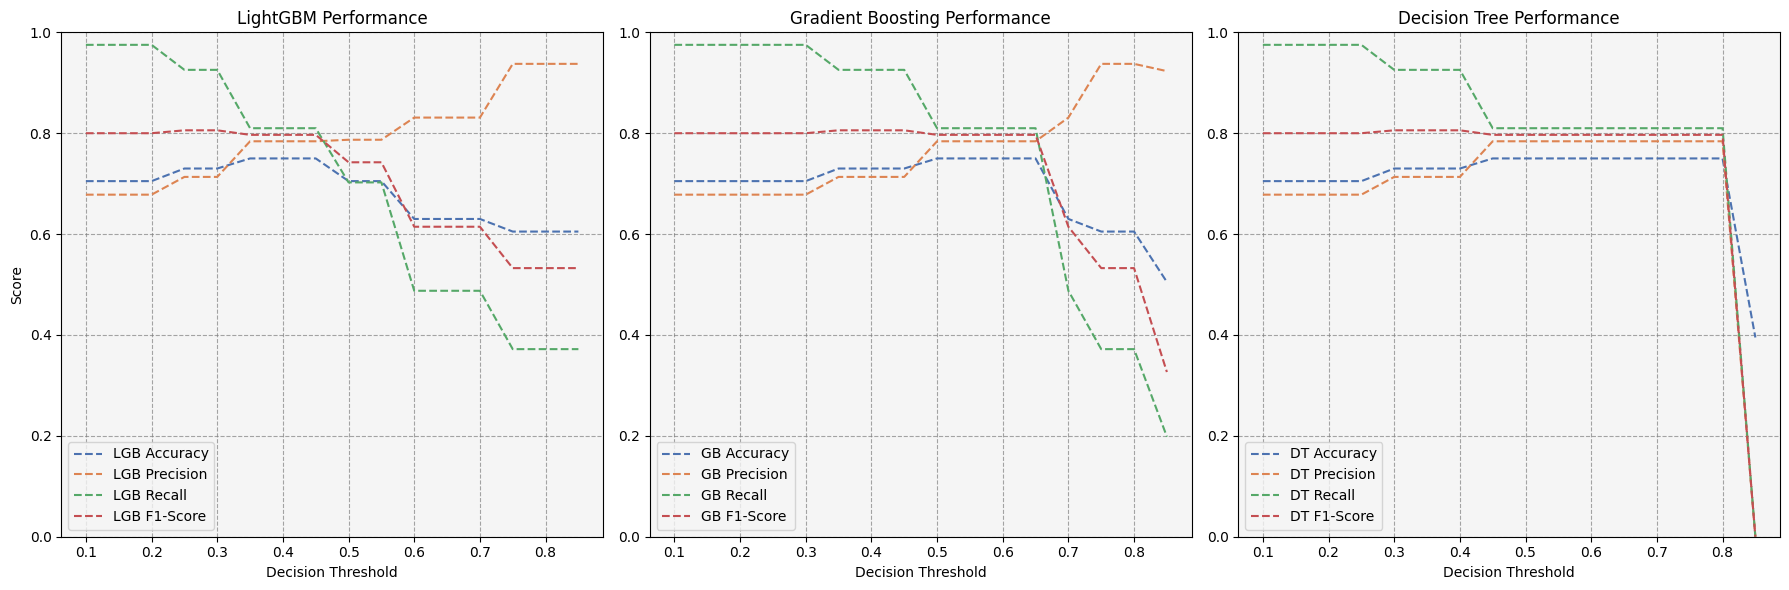

In [ ]:
# idea: evaluate LightGBM at different thresholds, compare to previous visualisation

# different thresholds 0.1 - 0.9, increments of 0.05
thresholds = np.arange(0.1, 0.9, 0.05)
LGB_results = []

# loop through each threshold
for threshold in thresholds:
    y_pred_LGB = (y_probs_LGB >= threshold).astype(int)

    # establish metrics
    precision = precision_score(y_test_cat_LGB, y_pred_LGB)
    recall = recall_score(y_test_cat_LGB, y_pred_LGB)
    f1 = f1_score(y_test_cat_LGB, y_pred_LGB)
    accuracy = accuracy_score(y_test_cat_LGB, y_pred_LGB)

    # store results
    LGB_results.append({
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# convert to DataFrame
LGB_results_df = pd.DataFrame(LGB_results)

# results sorted by threshold
print(LGB_results_df.sort_values(by = "Threshold"))

# subplots for LightGBM, Gradient Boosting, Decision Tree
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

# standardise y-axis across subplots
y_axis_range = (0, 1)

# background to match global setting
for ax in axes:
    ax.set_facecolor('whitesmoke')
    ax.grid(True, linestyle = '--', alpha = 0.7)

# LightGBM
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    axes[0].plot(
        thresholds,
        LGB_results_df[metric],
        label = f'LGB {metric}',
        linestyle = 'dashed'
    )

axes[0].set_title('LightGBM Performance')
axes[0].set_xlabel('Decision Threshold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(y_axis_range)
axes[0].legend()
axes[0].grid(True)

# gradient Boosting
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    axes[1].plot(
        thresholds,
        GB_results_df[metric],
        label = f'GB {metric}',
        linestyle = 'dashed'
    )

axes[1].set_title('Gradient Boosting Performance')
axes[1].set_xlabel('Decision Threshold')
axes[1].set_ylim(y_axis_range)
axes[1].legend(loc = 'lower left')
axes[1].grid(True)

# decision Tree
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    axes[2].plot(
        thresholds,
        DT_results_df[metric],
        label = f'DT {metric}',
        linestyle = 'dashed'
    )

axes[2].set_title('Decision Tree Performance')
axes[2].set_xlabel('Decision Threshold')
axes[2].set_ylim(y_axis_range)
axes[2].legend(loc = 'lower left')
axes[2].grid(True)

plt.tight_layout()

plt.show()

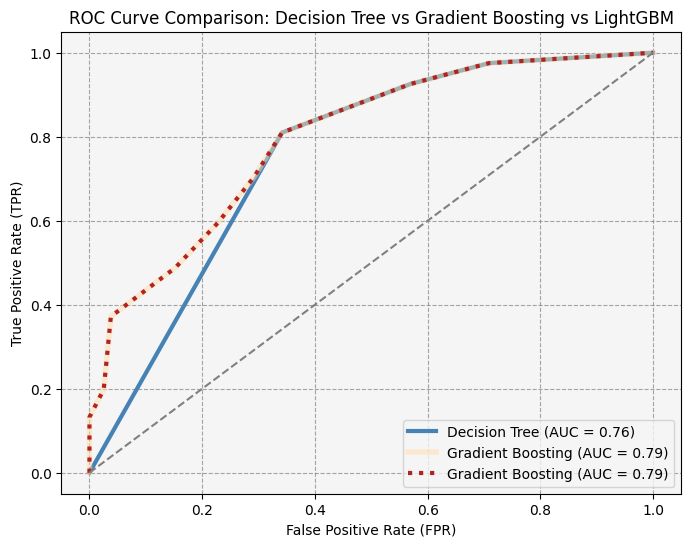

'\nwhy choose gradient boosting over decision tree: while the models perform (seemingly) identically in the prediction of unseen traffic being high or low, gradient boosting performs better\nin the discernment between the two at lower thresholds. This suggests that gradient boosting will perform better when the firm has control over the threshold used.\n'

In [ ]:
# idea: compare the AUC-ROC curve for each model

# initialise
DT_prob = clf_cat_best.predict_proba(X_test_cat)[:, 1]  # probability for positive class
GB_prob = clf_cat_GB_best.predict_proba(X_test_cat_GB)[:, 1]
LGB_prob = clf_cat_GB_best.predict_proba(X_test_cat_LGB)[:, 1]

# ROC curve for both models
fpr_DT, tpr_DT, _ = roc_curve(y_test_cat, DT_prob)
fpr_GB, tpr_GB, _ = roc_curve(y_test_cat_GB, GB_prob)
fpr_LGB, tpr_LGB, _ = roc_curve(y_test_cat_LGB, LGB_prob)

# calculate AUC score for both models
auc_DT = auc(fpr_DT, tpr_DT)
auc_GB = auc(fpr_GB, tpr_GB)
auc_LGB = auc(fpr_LGB, tpr_LGB)

plt.figure(figsize = (8, 6))

# AUC for decision tree, AUC for gradent boosting, diagonal line
plt.plot(
    fpr_DT,
    tpr_DT,
    color = 'steelblue',
    label = f'Decision Tree (AUC = {auc_DT.mean():.2f})',
    linewidth = 3
)
plt.plot(
    fpr_GB,
    tpr_GB,
    color = 'navajowhite',
    label = f'Gradient Boosting (AUC = {auc_GB.mean():.2f})',
    alpha = .5,
    linewidth = 4
)
plt.plot(
    fpr_LGB,
    tpr_LGB,
    color = 'firebrick',
    label = f'Gradient Boosting (AUC = {auc_GB.mean():.2f})',
    linestyle = 'dotted',
     linewidth = 3
)
plt.plot(
    [0, 1],
    [0, 1],
    color = 'gray',
    linestyle = '--'
)

plt.title('ROC Curve Comparison: Decision Tree vs Gradient Boosting vs LightGBM')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc = 'lower right')
plt.grid(True)

plt.show()

'''
why choose gradient boosting over decision tree: while the models perform (seemingly) identically in the prediction of unseen traffic being high or low, gradient boosting performs better
in the discernment between the two at lower thresholds. This suggests that gradient boosting will perform better when the firm has control over the threshold used.
'''